In [1]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation

from utils.models import LSTM



import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

pd.options.display.width = 1000


%load_ext tensorboard
!rm -rf ../workfiles/logs/
!rmdir  /S /Q "../workfiles/logs/"

rmdir: /S: No such file or directory
rmdir: /Q: No such file or directory
rmdir: ../workfiles/logs/: No such file or directory


Retaining patients that are included in phases 1 & 2
retaining all patient who have passed all visits...
loading samples...
loaded 1455 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
removing 6751 not found symbols from the dataset
removing 1504 ambigously positioned symbols from the dataset
selecting genes based on median absolute deviation threshold:  5 ...
0.0
4884.701


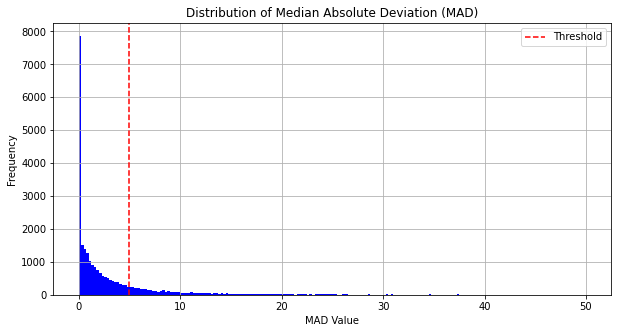

removing 20812 genes under the MAD threshold from the dataset
number of genes selected :  5204
sorting based on genomic position chr then transcript start...
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 1455
converting samples to time series
number of actual individual to be studied : 291
using transposed data...


In [5]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

absolute_path = "c:/thesis/data/quant"
metadata_path = "c:/thesis/METADATA_200123.xlsx"

x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    #path = absolute_path,
    #metadata_path = metadata_path,
    retain_phases = "Both",
    feature_selection_threshold = 5, 
    batch_size= 32,
    normalization = False,
    transpose=True,
    as_time_series = True,
    MT_removal = True,
    log1p = True,
    min_max=True,
    keep_only_symbols=True,
    drop_ambiguous_pos=True,
    sort_symbols=True)

In [10]:
importlib.reload(LSTM) # to allow modification of the script without restarting the whole session

latent_dim = 32
sequence_length = 5

t_shape = (sequence_length, n_genes)

# SINCE WE USE TRANSPOSE :
t_shape = (n_genes, sequence_length)


autoencoder = LSTM.generate_model(t_shape, latent_dim, True)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [11]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=50, min_lr=0.000001)


early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=75)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, 
      reduce_lr, 
      #early_stopping_callback, 
      tensorboard_callback]

In [12]:
#%tensorboard --logdir ../workfiles/logs/fit

4k ish

12K for 512 + 256


very unstable training on small batch size



In [13]:
hist = autoencoder.fit(x_train, epochs=3, callbacks=cb)

Epoch 1/5
10/10 [==============================] - 233s 22s/step - loss: 0.1837 - lr: 0.0010
Epoch 2/5
10/10 [==============================] - 219s 22s/step - loss: 0.0322 - lr: 0.0010
Epoch 3/5
10/10 [==============================] - 233s 23s/step - loss: 0.0274 - lr: 0.0010
Epoch 4/5
10/10 [==============================] - 264s 27s/step - loss: 0.0267 - lr: 0.0010
Epoch 5/5
10/10 [==============================] - 274s 27s/step - loss: 0.0264 - lr: 0.0010


10/10 [==============================] - 10s 960ms/step - loss: 8.2001e-04 - lr: 1.0000e-05


In [14]:
autoencoder.load_weights(checkpoint_filepath)


[0.11531691998243332, 0.030809573829174042, 0.027127234265208244, 0.0264531709253788, 0.026138558983802795]


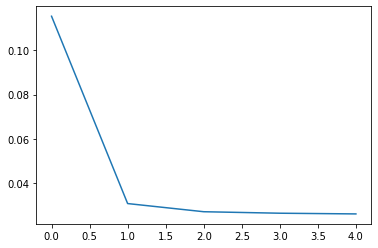

In [15]:
plt.plot(hist.history['loss'][0:])
print(hist.history['loss'])

In [24]:
importlib.reload(benchmark) # to allow modification of the script without restarting the whole session
benchmark.benchmark(autoencoder, x_train)

benchmarking model : LSTM_t
number of parametters of the model: 685568
shape of the dataset: (291, 5204, 5)
the dataset meets the min_max requirement


### some diagnosis

In [25]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_single_obs_processing(x_train, autoencoder)

In [22]:
autoencoder.encoder.save('../workfiles/T_LSTM')


INFO:tensorflow:Assets written to: ../workfiles/T_LSTM\assets


INFO:tensorflow:Assets written to: ../workfiles/T_LSTM\assets


In [15]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

10/10 [==============================] - 4s 284ms/step


In [16]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [19]:
df.to_csv("../workfiles/processed_data_t_lstm.csv", index=False)


# Viz

10/10 [==============================] - 14s 1s/step


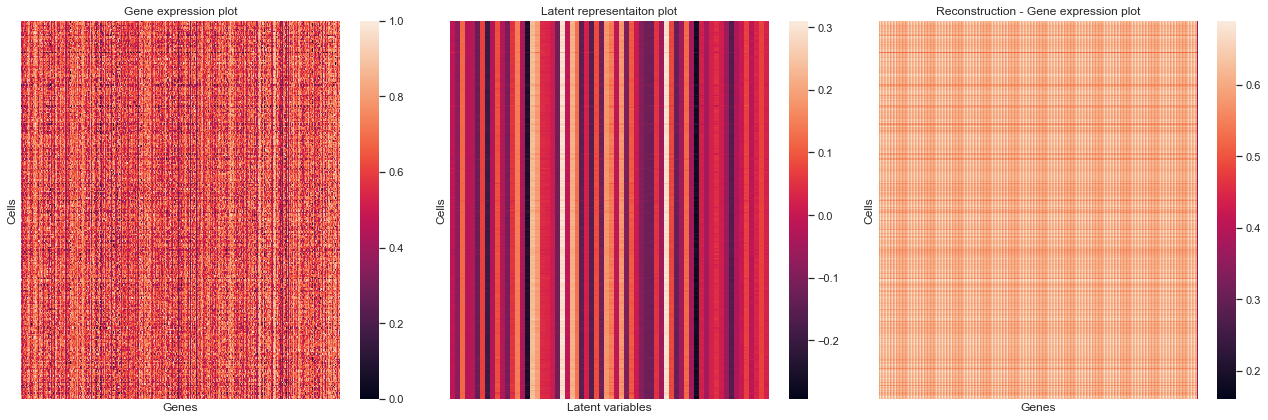

In [22]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_dataset_processing(x_train, autoencoder)